[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

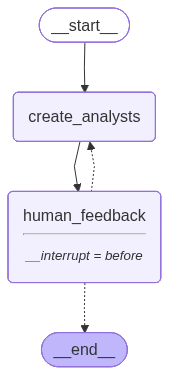

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework meets industry standards for data protection and privacy. He provides recommendations for secure implementation practices.
----------------------------------------

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTP

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6866-dc6d-6708-8002-7ac8187adf4e'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework meets industry standards for data protection and privacy. He provides recommendations for secure implementation practices.
----------------------------------------

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b6867-206f-639d-8004-30e8b4f48dc0'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Startup Entrepreneur
Description: Alex is a startup founder who is keen on leveraging cutting-edge technologies to gain a competitive edge. His focus is on how adopting LangGraph can streamline operations, reduce costs, and enhance product offerings. He is particularly interested in the scalability and flexibility of LangGraph as a framework that can adapt to the fast-paced changes in the startup ecosystem.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Global Tech Solutions
Role: AI Research Scientist
Description: Dr. Carter is an AI research scientist with a focus on agent-based modeling and frameworks. Her interest in LangGraph lies in its potential to advance AI research by providing a robust and flexible framework for developing intelligent agents. She is concerned with the technical capabilities of LangGraph, such as its support for complex interactions and ease of integration with 

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [19]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18568\2675700386.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

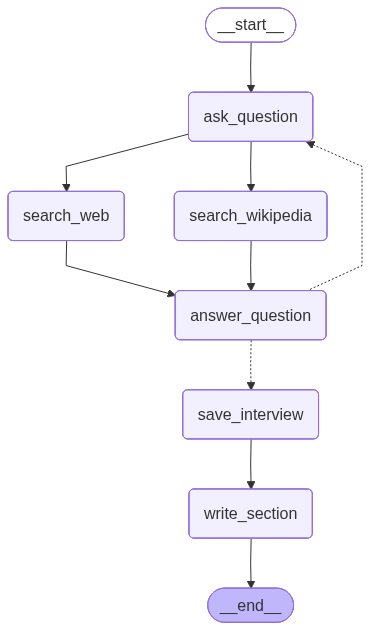

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alex Johnson', role='Startup Entrepreneur', description='Alex is a startup founder who is keen on leveraging cutting-edge technologies to gain a competitive edge. His focus is on how adopting LangGraph can streamline operations, reduce costs, and enhance product offerings. He is particularly interested in the scalability and flexibility of LangGraph as a framework that can adapt to the fast-paced changes in the startup ecosystem.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Leveraging LangGraph for Startup Success: Streamlining Operations and Enhancing Product Offerings

### Summary

In the fast-paced startup ecosystem, leveraging cutting-edge technologies is crucial for gaining a competitive edge. LangGraph, a powerful multi-agent framework, offers a promising solution for startups looking to streamline operations, reduce costs, and enhance product offerings. This report explores the scalability and flexibility of LangGraph, highlighting its potential to adapt to the dynamic needs of startups.

LangGraph provides a set of prebuilt components that simplify the development of agentic systems, allowing startups to focus on application logic rather than infrastructure [1]. This framework supports both declarative and imperative programming styles, offering flexibility in how agents are developed and managed [2]. The ability to control agent interactions precisely, with workflows that can pause for decisions or inputs, mirrors the dynamics of human teams and enhances efficiency [3].

One of the standout features of LangGraph is its scalability. It enables the creation of complex, stateful applications using large language models (LLMs), making it ideal for startups aiming to build intelligent solutions [4]. Companies like Uber and Replit have already demonstrated LangGraph's potential by automating unit test generation and powering real-time code generation, respectively, showcasing its ability to reduce development time and improve code quality [5].

LangGraph's modular approach allows for the design of flexible and coordinated workflows, which is particularly beneficial for startups that need to pivot quickly in response to market changes [6]. The framework's support for multi-agent orchestration patterns and expert prompt engineering accelerates productivity, making it a valuable asset for data science and machine learning teams [7].

Moreover, LangGraph's human-on-the-loop feature provides built-in support for inspecting and modifying agent trajectories, ensuring that startups can maintain control over their AI systems and adapt them as needed [2]. This capability is crucial for startups that require agile and responsive AI solutions.

In summary, LangGraph offers a robust framework for startups to build scalable, flexible, and efficient AI-driven solutions. Its ability to streamline operations, reduce costs, and enhance product offerings makes it an attractive option for startup founders like Alex, who are keen on leveraging cutting-edge technologies to gain a competitive edge.

### Sources
[1] https://langchain-ai.github.io/langgraph/agents/overview/  
[2] https://blog.langchain.com/how-to-think-about-agent-frameworks/  
[3] https://www.scalablepath.com/machine-learning/langgraph  
[4] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic  
[5] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  
[6] https://www.codersarts.com/post/top-20-langgraph-trending-projects-assignments  
[7] https://www.codersarts.com/post/top-20-langgraph-trending-projects-assignments  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18568\3790429458.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


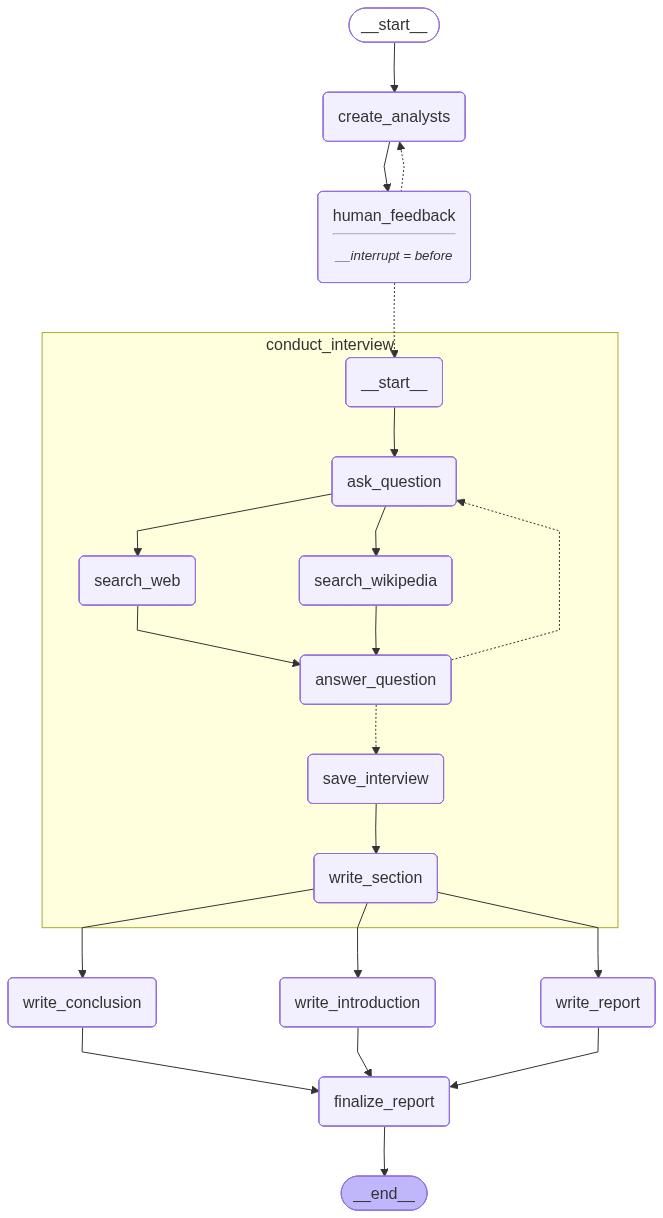

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework complies with industry standards and best practices. He aims to provide a comprehensive risk assessment for organizations considering LangGraph.
------------------

In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b686a-2715-69b6-8002-ae05261fa5b7'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Cybersecurity Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring that the framework complies with industry standards and best practices. He aims to provide a comprehensive risk assessment for organizations considering LangGraph.
------------------

In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b686a-5869-68d2-8004-20080a1835c3'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the dynamic realm of artificial intelligence, the quest for frameworks that enhance efficiency and scalability is relentless. LangGraph stands out as a transformative agent framework, offering a graph-based architecture that excels in managing complex AI operations. This report delves into LangGraph's unique advantages, such as its ability to maintain context across workflows, its modular design, and its seamless integration with the LangChain ecosystem. By exploring its economic benefits, strategic edge for startups, and potential for accelerating innovation, we uncover how LangGraph empowers businesses to achieve significant cost savings, improved ROI, and a competitive advantage in the AI landscape.

---



LangGraph emerges as a transformative agent framework in the rapidly evolving landscape of artificial intelligence, offering significant advantages in efficiency, scalability, and economic benefits. Its graph-based architecture is particularly beneficial for complex AI operations, supporting cyclical workflows that enable advanced state management and dynamic behavior. This makes LangGraph an ideal choice for applications requiring long-running, multi-step tasks where maintaining context is crucial [1][2][3].

One of LangGraph's standout features is its ability to manage state explicitly, allowing AI agents to carry context across different steps. This capability is essential for scenarios such as customer support bots, research assistants, and process automation systems that operate over extended periods, reducing errors and enhancing reliability [1]. The framework's modular design and visual interface simplify the creation of complex workflows, supporting the integration of modular components to form dynamic workflows. This is crucial for handling feedback loops, decision-making processes, and multi-step tasks, making LangGraph well-suited for real-time interactions and business process automation [2]. Its deep integration with the LangChain ecosystem provides access to a vast library of pre-made agents, tools, and connectors, enhancing its versatility and ease of use [3].

LangGraph's graph-based model allows for the creation of flows with branching, looping, and revisiting earlier steps, providing developers with explicit control over the flow of logic. This flexibility is a significant departure from the more linear, directed acyclic graphs (DAGs) found in other data orchestration frameworks, making it crucial for developing sophisticated agent runtimes capable of handling complex, real-world scenarios [4][5]. Additionally, LangGraph excels in scalability, supporting parallel execution of independent operations, which significantly improves efficiency for workflows with multiple concurrent tasks [4]. Its robust Human-in-the-Loop (HitL) capabilities enable human intervention at any point within an agent’s runtime, ensuring workflows can be paused and adjusted as needed [3].

Economically, LangGraph offers substantial benefits by automating and augmenting complex workflows, allowing companies to deliver decisions and services with unprecedented speed and responsiveness. This strategic shift enhances customer responsiveness, data analysis, and innovation capacity, positioning AI initiatives as long-term strategic assets [1]. LangGraph's stateful orchestration allows AI agents to revisit previous steps based on new information or changing conditions, making it attractive for enterprises implementing sophisticated AI systems [2]. Its integration capabilities, such as with LangChain, have demonstrated significant improvements in risk assessment accuracy and reductions in compliance-related delays [2].

Despite its strengths, LangGraph lacks the autonomous decision-making and self-improvement capabilities of more agentic frameworks like AutoGPT and BabyAGI [3]. However, its structured control and ability to orchestrate complex workflows make it a valuable tool for businesses seeking to harness AI without fully autonomous systems.

For startups, LangGraph accelerates innovation and streamlines product development by providing prebuilt components that simplify the development of agentic systems, allowing a focus on application logic rather than infrastructure [1]. Its support for both declarative and imperative programming styles offers flexibility in agent development and management [2]. The "human-on-the-loop" capability allows users to inspect and modify agent trajectories, enhancing adaptability [2]. LangGraph's orchestration of complex workflows enables parallel processing and decision-making phases that mimic human team dynamics, aligning with the startup ethos of rapid iteration and deployment [1]. Its adaptability is further highlighted by support for various APIs, catering to different developer preferences and project requirements [2]. The framework's ability to democratize data access and enhance productivity is exemplified by LinkedIn's use of LangGraph to develop the SQL Bot, empowering employees to independently extract insights from data [4].

In conclusion, LangGraph offers a comprehensive solution for building intelligent, scalable, and efficient AI systems. Its graph-based architecture, modular design, and integration capabilities make it a standout choice for developers and businesses looking to streamline complex AI operations, enhance performance, and achieve significant economic benefits.


---

## Conclusion

LangGraph stands out as a transformative agent framework in the AI landscape, offering a graph-based architecture that enhances efficiency, scalability, and adaptability. Its ability to manage state explicitly and support complex workflows makes it ideal for applications requiring long-running, multi-step tasks. The framework's modular design and integration with the LangChain ecosystem further simplify the creation of dynamic workflows, providing significant economic benefits and a competitive edge for businesses. While it lacks some autonomous capabilities, LangGraph's structured control and orchestration of complex workflows make it a valuable tool for startups and enterprises alike, driving innovation and operational efficiency.

## Sources
[1] https://www.truefoundry.com/blog/autogen-vs-langgraph  
[2] https://oxylabs.io/blog/langgraph-vs-langchain  
[3] https://www.3pillarglobal.com/insights/blog/comparison-crewai-langgraph-n8n/  
[4] https://medium.com/@saimoguloju2/langgraph-building-intelligent-multi-agent-workflows-with-state-management-0427264b6318  
[5] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications  
[6] https://www.scalablepath.com/machine-learning/langgraph  
[7] https://blog.agen.cy/p/agency-revolutionizing-ai-development  
[8] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857  
[9] https://langchain-ai.github.io/langgraph/agents/overview/  
[10] https://blog.langchain.com/how-to-think-about-agent-frameworks/  
[11] https://blog.langchain.com/is-langgraph-used-in-production/  
[12] https://www.linkedin.com/posts/langchain_top-5-langgraph-agents-in-production-2024-activity-7278807039521239040-TMbV

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

In [39]:


import os
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
search_tool = TavilySearchResults(max_results=3)


class RAState(MessagesState):
    question: str
    docs: list
    sources: list
    answer: str


def entry_node(state: RAState):
    question = state["messages"][-1].content if state["messages"] else ""
    return {"question": question}


def web_search_node(state: RAState):
    question = state["question"]
    print(f"🔍 Searching the web for: {question}")
    try:
        results = search_tool.invoke({"query": question})
        docs = [r["content"] for r in results if "content" in r]
        sources = [r["url"] for r in results if "url" in r]
    except Exception:
        docs = [
            "AI helps predict natural disasters and optimize energy use.",
            "Machine learning is improving renewable energy forecasting.",
            "AI supports researchers in analyzing climate data more efficiently."
        ]
        sources = ["https://example.com"]
    return {"docs": docs, "sources": sources}


def summarize_docs(state: RAState):
    docs = state.get("docs", [])
    question = state.get("question", "")
    summaries = []

    for doc in docs[:3]:  # limit for simplicity
        prompt = [
            HumanMessage(
                content=f"Question: {question}\n\nDocument:\n{doc}\n\nSummarize key points relevant to the question."
            )
        ]
        resp = llm.invoke(prompt)
        summaries.append(resp.content)
    return {"summaries": summaries}


def combine_summaries(state: RAState):
    summaries = state.get("summaries", [])
    sources = state.get("sources", [])
    question = state.get("question", "")

    combined = "\n\n".join(summaries)
    sources_text = "\n".join(f"- {s}" for s in sources)

    prompt = [
        HumanMessage(
            content=(
                f"User question: {question}\n\nSummaries:\n{combined}\n\n"
                "Write a clear and short answer that combines the information.\n"
                f"At the end, include:\n\nSources:\n{sources_text}"
            )
        )
    ]
    resp = llm.invoke(prompt)
    return {"answer": resp.content, "messages": [AIMessage(resp.content)]}


workflow = StateGraph(RAState)
workflow.add_node("entry", entry_node)
workflow.add_node("search", web_search_node)
workflow.add_node("summarize", summarize_docs)
workflow.add_node("combine", combine_summaries)

workflow.add_edge(START, "entry")
workflow.add_edge("entry", "search")
workflow.add_edge("search", "summarize")
workflow.add_edge("summarize", "combine")
workflow.add_edge("combine", END)

graph = workflow.compile()


user_question = "How is AI being used to fight climate change?"
input_message = HumanMessage(content=user_question)

output = graph.invoke({"messages": [input_message]})

for m in output.get("messages", []):
    if hasattr(m, "pretty_print"):
        m.pretty_print()

print("\n--- Final Answer ---")
print(output["answer"])


display(Image(graph.get_graph(xray=1).draw_mermaid_png()))






🔍 Searching the web for: How is AI being used to fight climate change?
================================ Human Message =================================

How is AI being used to fight climate change?
================================== Ai Message ==================================

AI is being utilized in various ways to combat climate change, including optimizing energy consumption, enhancing renewable energy integration, improving climate modeling and predictions, and facilitating carbon capture and storage. It helps in monitoring environmental changes, predicting extreme weather events, and enabling smarter agricultural practices to reduce emissions. Additionally, AI can analyze vast datasets to identify patterns and solutions for sustainability challenges.

Sources:
- https://www.weforum.org/stories/2024/02/ai-combat-climate-change/
- https://hub.jhu.edu/2023/03/07/artificial-intelligence-combat-climate-change/
- https://unu.edu/ehs/series/5-insights-ai-double-edged-sword-climate-act

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00|\x00\x00\x02\x13\x08\x02\x00\x00\x00JA\xefO\x00\x00\x10\x00IDATx\x9c\xec\x9d\x07|\x14\xc5\x17\xc7g\xf7Zz\x0f\xa4\x11\x92\x00\xa1\x85\x1e:\x82\x94\xd0\x11\x10\xfe\xf4\xde\x05\x94\x16Q\xa4\t\xa24Q\x94"b\x01\xa4H\x95\xa6\x14\x05\x14\x04\x94\xde\x95\x92\x90@\x12H\x80$\xa4\xe7.w\xbb\xffw\xb7\xe1r\tw\x98\xbd\xdb\xcdd\x93\xf9~\xc2\xb17;\xbb\xb7\xfb\xdb\xd97\xb33\xb3\xef\xc9Y\x96E\x84\x92E\x8e\x08%\x0e\x11\x1d\x03Dt\x0c\x10\xd11@D\xc7\x00\x11\x1d\x03"\x8a\x1e}=\xfd\xee\xd5\xac\xf4\xa7\x1am\x1e\xd2\xe6\xe9\x10\xa2\x8bd\xa0h\x8ae\xf2\x1b\xac\x14B\xb0D\xd3\x14\xc3\xb0\xdcg\xd1\xcc\x14\x05\xad[\x8aB\\\x13\xd7\x98\x07R`\xdb"\xd9\x8d\xd9\xf49e\x14\xa3c\xb9\xcd\x8b\xac5M\xe4\x90\xc9(\x85\x1d\xe5\xe4*\xabT\xdd\xa1n+w$\x0e\x94\xe0\xed\xf4\x8b\xc7\x92o\x9eM\xcfJ\xd3\xc1\x8eer\xa4PR*{\x19\xc32\x14#3\xe6a\x11\x0bZQ4b\x19\x93\xb4\x17)\x05\xe9\x94!#\x07\\2\xe6\xc5\'2\xcd\xf3b\x7f\x85N\xcb\x90f\xf8\x15Z\x86\x18\xdd\x8b\xab\xca\xfd\x12\xa5\xdfq\xc1>M\xa0e\xfab